The following notebook contains the code and analysis required to develop a computer vision model for predicting poverty in Ethiopia using satellite imagery from Google Static Maps and Google Earth Engine and socioeconomic data from the World Bank and the Central Statistical Agency of Ethiopia.

This notebook borrows heavily from the work of Jean et Al (Source: https://science.sciencemag.org/content/353/6301/790) & Johanthan Whitaker (Source: https://datasciencecastnet.home.blog/2019/11/12/deep-learning-remote-sensing-using-nns-to-turn-imagery-into-meaningful-features/)

Works Cited:

Central Statistical Agency of Ethiopia. Ethiopia Socioeconomic Survey (ESS4) 2018-2019. Public Use Dataset. Ref: ETH_2018_ESS_v01. Downloaded from https://microdata.worldbank.org/index.php/catalog/3823 on March 1, 2021.

Gorelick, N., Hancher, M., Dixon, M., Ilyushchenko, S., Thau, D., & Moore, R. (2017). Google Earth Engine: Planetary-scale geospatial analysis for everyone. Remote Sensing of Environment.

Jean, N., Burke, M., Xie, M., Davis, W. M., Lobell, D.B., and Ermon, S., 2016. Combining satellite imagery and machine learning to predict poverty. Science 353 (6301), 790-794.

Loading & Cleaning Socioeconomic Data

In [209]:
#Package imports
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import IPython.display as ipd
from google.colab import files
import ee
import math
import random
import os.path
from google.colab import drive
import glob
from fastai.vision import *
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [17]:
#Uploading data
#Source: https://microdata.worldbank.org/index.php/catalog/lsms
uploaded = files.upload()

Saving cons_agg_w4.csv to cons_agg_w4 (1).csv
Saving ETH_HouseholdGeovariables_Y4.csv to ETH_HouseholdGeovariables_Y4 (1).csv


In [18]:
#Preparing household consumption data 
#Source: https://microdata.worldbank.org/index.php/catalog/3823/data-dictionary/F63?file_name=cons_agg_w4.dta
df = pd.read_csv('cons_agg_w4.csv')
df['cons'] = df['nom_totcons_aeq']/(365*df['adulteq']) #total annual per capita consumption within household / num of equiv adults within household * 365 days
df.rename(columns={'pw_w4': 'weight'}, inplace=True) #household sampling weight
df.rename(columns={'saq14': 'urban_rural'}, inplace=True) 
df["urban_rural"].replace({"URBAN": 2, "RURAL": 1}, inplace=True)
df = df[['ea_id','household_id', 'cons', 'weight','urban_rural']]
df

,ea_id,household_id,cons,weight,urban_rural
0,10601010100215,010601010100215268,139.532897,2323.239910,2
1,150101088802908,150101088802908013,19.719414,38.907193,1
2,60206088800904,060206088800904010,55.974439,179.601728,1
3,150101088802010,150101088802010033,3.104349,240.133971,1
4,40212088800506,040212088800506137,9.966519,12467.555689,1
...,...,...,...,...,...
6765,50109088800301,050109088800301014,27.756285,1822.197438,1
6766,140104010100403,140104010100403195,13.148613,1485.710936,2
6767,20503010100101,020503010100101104,4.678024,347.453880,2
6768,30701088800919,030701088800919090,5.237460,8543.574317,1


In [19]:
#Preparing household geolocation data
#Source: https://microdata.worldbank.org/index.php/catalog/3823/data-dictionary/F67?file_name=ETH_HouseholdGeovariables_Y4.dta
df_geo = pd.read_csv('ETH_HouseholdGeovariables_Y4.csv')
df_loc = df_geo[['ea_id','household_id', 'lat_mod', 'lon_mod']].copy()
df_loc.rename(columns={'lat_mod': 'lat', 'lon_mod': 'lon'}, inplace=True)
df_loc

,ea_id,household_id,lat,lon
0,10101088800910,010101088800910007,14.258308,37.809654
1,10101088800910,010101088800910017,14.258308,37.809654
2,10101088800910,010101088800910026,14.258308,37.809654
3,10101088800910,010101088800910029,14.258308,37.809654
4,10101088800910,010101088800910038,14.258308,37.809654
...,...,...,...,...
6799,150101088803701,150101088803701057,9.504422,41.663799
6800,150101088803701,150101088803701067,9.504422,41.663799
6801,150101088803701,150101088803701077,9.504422,41.663799
6802,150101088803701,150101088803701087,9.504422,41.663799


In [20]:
#Combining consumption data with geolocation data
df_combined = pd.merge(df, df_loc, on='household_id')
df_combined = df_combined[['household_id','cons','weight','urban_rural','lat','lon']]
df_combined.dropna()
df_combined.drop_duplicates(subset=['household_id'])

#Creating clusters for households within 10km
df_combined['lat_10km'] = df_combined['lat'].round(decimals=3) #3 decimals lat/lon is within 10km
df_combined['lon_10km'] = df_combined['lon'].round(decimals=3)
df_combined['cluster'] = df_combined['lon_10km'].astype(str)+df_combined['lat_10km'].astype(str)

#Creating cluster df 
clusters = df_combined.groupby('cluster').mean()
clusters['household_id'] = df_combined.groupby('cluster').first()['household_id']
clusters = clusters.dropna()
print(clusters.shape) #check # of clusters
clusters

(515, 8)


,cons,weight,urban_rural,lat,lon,lat_10km,lon_10km,household_id
cluster,,,,,,,,
33.4358.368,15.201997,113.606275,2.0,8.368388,33.434830,8.368,33.435,120203010100102013
33.688.307,16.460019,93.219010,2.0,8.306919,33.679806,8.307,33.680,120205010100101163
33.7698.331,3.919900,157.518797,1.0,8.330982,33.769154,8.331,33.769,120202088802101032
33.9498.331,38.419464,132.299962,2.0,8.330856,33.948551,8.331,33.949,120201010100102040
33.958.321,4.019047,314.250000,1.0,8.320701,33.950245,8.321,33.950,120201088802501008
...,...,...,...,...,...,...,...,...
44.6485.237,3.092973,1870.116737,1.0,5.236537,44.647781,5.237,44.648,050606088800801109
44.9747.548,24.312164,1415.832804,1.0,7.547618,44.974194,7.548,44.974,050506088800603008
45.1127.923,28.154817,1929.297647,1.0,7.923481,45.112167,7.923,45.112,050304088801205002


Extracting and Preparing Satellite Image Data from Google Static Maps & Google Earth Engine



In [21]:
#Verifying Google Earth Engine Credentials
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=-Gbn7SkfH8K4xy2jwkpCNU2jjkRnEVYddZpkfs40p48&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5ew-Tt-GFOktdgbzBfgdrIVADLSHJi4ffvtJ8Q3Yoiq8eaOQ_7FSM

Successfully saved authorization token.


In [22]:
#Initializing the library
ee.Initialize()

In [23]:
#Loading nighttime lights image data
dmsp_ols = ee.ImageCollection('NOAA/DMSP-OLS/NIGHTTIME_LIGHTS')
lights = dmsp_ols.filterDate('2012-1-30', '2014-01-01').first() # 2013 is last date

#Function to obtain the mean # of lights over an area 
def lights_at_points(lats, lons, buf_dist=5000):
  buffers = []
  for lat, lon in zip(lats, lons):
    xy = ee.Geometry.Point([lon, lat])
    buf = xy.buffer(buf_dist) 
    buffers.append(buf)
  vals = lights.reduceRegions(collection=ee.FeatureCollection(buffers), reducer=ee.Reducer.mean()).getInfo()
  return [v['properties']['stable_lights'] for v in vals['features']]

In [24]:
#Appending nightlights to data (and dropping all clusters with 0 lights)
clusters['NL'] = lights_at_points(clusters['lat'].values, clusters['lon'].values)
clusters = clusters[(clusters[['NL']] != 0).all(axis=1)]
clusters

,cons,weight,urban_rural,lat,lon,lat_10km,lon_10km,household_id,NL
cluster,,,,,,,,,
34.52510.063,101.569738,339.596941,2.0,10.062950,34.524731,10.063,34.525,060108010100205057,4.359860
34.53910.067,90.525371,476.749890,2.0,10.067476,34.539162,10.067,34.539,060108010100319013,4.479612
34.54410.079,63.728811,745.401037,2.0,10.079482,34.543869,10.079,34.544,060108010100106294,4.480569
34.5610.066,44.079917,326.008692,2.0,10.065826,34.560162,10.066,34.560,060108010100415066,4.166496
34.5738.237,44.654402,174.153897,2.0,8.237496,34.573288,8.237,34.573,120106010100525132,3.150290
...,...,...,...,...,...,...,...,...,...
43.1439.082,9.551619,1784.685286,1.0,9.081748,43.143341,9.082,43.143,050206088801407038,0.501800
43.5445.967,10.769775,962.451337,2.0,5.967321,43.544323,5.967,43.544,050611010100206109,2.562171
43.5588.213,26.545926,777.817815,2.0,8.213417,43.558174,8.213,43.558,050312010101002082,0.525796


In [26]:
#Defining ImageryDownloader Class
class ImageryDownloader:
    def __init__(self, access_token):
        self.access_token = access_token
        self.url = 'https://maps.googleapis.com/maps/api/staticmap?center={},{}&zoom={}&size=400x400&maptype=satellite&key={}'
    
    #This function downloads images from Google Static Maps (Lat,Long)
    def download(self, lat, long, zoom):
        res = requests.get(self.url.format(lat, long, zoom, self.access_token))
        image = Image.open(BytesIO(res.content))
        return image

In [ ]:
#Mounting drive to the file system
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#Creating a directory to store image data
#!mkdir 'gdrive/My Drive/DLRS' 
path = 'gdrive/My Drive/DLRS/'

In [ ]:
#Formatting train df
rows = []
for c, w, u, y, x, lt, ln, hhid, nl in clusters.values:
  for i in range(20):
    max_d_lat = 8*(1/110)
    max_d_lon = 8*(1/(110*math.cos(math.radians(y))))
    x_new = x + 2*(random.random()-0.5)*max_d_lon
    y_new = y + 2*(random.random()-0.5)*max_d_lat
    rows.append([hhid, x_new, y_new, nl])
train = pd.DataFrame(rows, columns=["household_id", "X", "Y",  "NL"])
train.shape

(4500, 4)

In [ ]:
#Updating NL data using Google Eearth Engine
nls = []
for i in range(0, len(train), 3000):
  ls = lights_at_points(train['Y'].values[i:min(i+3000, len(train))], train['X'].values[i:min(i+3000, len(train))], buf_dist=300)
  nls += ls
train['NL'] = nls

In [ ]:
#Downloading images to Google Drive
fns = []
for hhid, x, y, nl in train.values:
  fn = path + str(hhid) + "_" + str(x) + "_" + str(y) + "_" + 'GSM.png'
  if not os.path.isfile(fn):
    im_dl.download(y, x, 16).save(fn)
  fns.append((hhid, x, y, nl, fn))

#Globbing img paths
ims = glob.glob(path+"/*")

In [ ]:
#Adding img paths to train df
train['img_path'] = path + train['household_id'] + "_" + train["X"].astype(str) + "_" + train["Y"].astype(str) + "_" + 'GSM.png'
train = train.loc[train['img_path'].isin(ims)] #Filter out img paths with no corresponding img

In [ ]:
#Saving training data for modelling
#train.to_csv(path+"img_locs_w_fns_w_nls.csv", index=False) 

Modelling the Data (GPU Starts Here)

In [31]:
# Mounting drive to the file system
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
path = 'gdrive/My Drive/DLRS/'

In [33]:
train = pd.read_csv(path+"img_locs_w_fns_w_nls.csv")

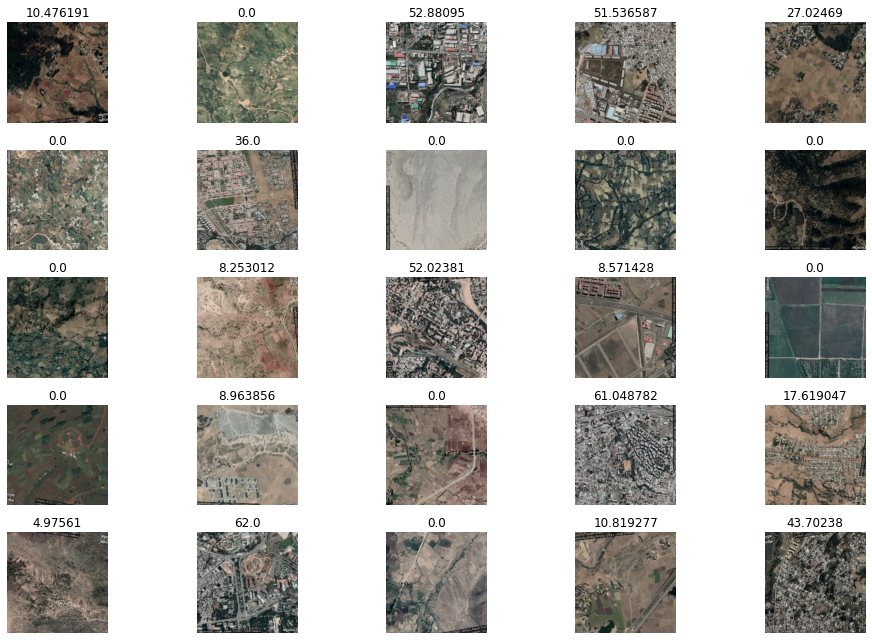

In [ ]:
#Transforming image data for modelling using fast ai (Defaults)
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.) 
np.random.seed(666)
ims = train[['img_path', 'NL']]
src = (ImageList.from_df(df=ims, path='')
       .split_by_rand_pct(0.1)
       .label_from_df(cols='NL', label_cls=FloatList))

#Reducing imgs to 200px for the sake of processing time
data = (src.transform(tfms, size=200)
        .databunch().normalize(imagenet_stats))

#Visualizing data
data.show_batch(rows=5, figsize=(14,9))

In [ ]:
#Downloading pre-trained CV CNN for use in modelling (Source: https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py)
learn = cnn_learner(data, models.vgg11_bn, metrics=[r2_score, rmse]) 
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


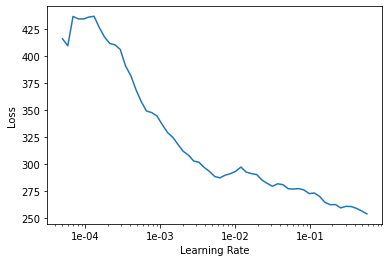

In [ ]:
#Defining loss function
learn.loss_func = MSELossFlat()

#Finding the optimal learning rate
learn.lr_find(start_lr=1e-5, end_lr=1e2)
learn.recorder.plot()

In [ ]:
#Fitting the data
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,132.304260,251.128693,0.134509,15.694783,00:39
1,82.551559,49.313919,0.827460,6.954896,00:39
2,55.904343,33.228531,0.881328,5.726439,00:40
3,45.541138,25.453100,0.908982,4.972501,00:40
4,38.704548,22.196257,0.918883,4.660725,00:40


0.9266990639107507


Text(0, 0.5, 'Predicted NL values')

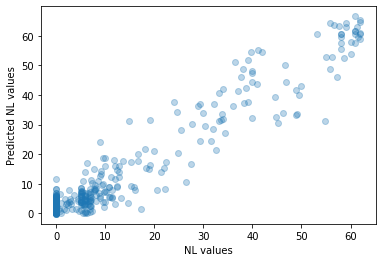

In [ ]:
#Evaluating ability to predict NL values on per image basis
preds, y = learn.get_preds()
ps = [float(p) for p in preds]
ys = [float(p) for p in y]
from sklearn import metrics
print(metrics.r2_score(ys, preds))
plt.scatter(ys, preds, alpha=0.3)
plt.xlabel("NL values")
plt.ylabel("Predicted NL values")

In [ ]:
#Saving the model
learn.save('baseline_model')

Using the Model as a Feature Extractor

In [28]:
#Source: https://towardsdatascience.com/finding-similar-images-using-deep-learning-and-locality-sensitive-hashing-9528afee02f5

#This class saves features from the last FC layer of the model (intact)
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [ ]:
#Extracting output before last fully connected layer
sf = SaveFeatures(learn.model[-1][-5])

#Saving feature variables in df
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

#Converting to a dictionary
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

#Checking # of features
len(list(feature_dict.values())[0])

In [ ]:
#Mapping features to a list
features = ("./" + train['img_path']).map(feature_dict)

#Reducing the number of features using PCA
pca = decomposition.PCA(n_components=30)
top_features = pca.fit_transform(np.asarray([f for f in features]))
top_features[0].shape

In [ ]:
#Appending features to train df
for i in range(len(top_features)):
  train["P" + str(i).zfill(2)] = [fs[i] for fs in top_features]
train.head()

In [ ]:
#Saving the train df with features
#train.to_csv(path+'train_w_features_vgg11_512(-1, -5)_regression.csv', index=False)

Predicting Consumption Using the Extracted Features

In [34]:
#Loading 
train = pd.read_csv(path+"train_w_features_vgg11_512(-1, -5)_regression.csv")

In [196]:
#Creating and cleaning a features df
features_df = train.groupby('household_id').mean() #Grouping by cluster
features_df = pd.merge(features_df, clusters[['household_id', 'cons', 'NL']], how='left', on='household_id') #Adding target variable to df (Consumption)
features_df = features_df.dropna()
features_df

,household_id,X,Y,NL_x,P00,P01,P02,P03,P04,P05,P06,P07,P08,P09,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,cons,NL_y
0,010102088801010113,38.166200,14.378429,0.052893,-185.342432,19.888459,-24.854298,-16.331145,7.201678,8.410035,1.427531,-1.694439,-1.191903,3.188261,2.029180,1.203533,-0.982767,-0.478110,-0.284933,-2.050986,-0.867296,-0.626181,0.976876,0.091083,1.940638,-0.130070,-0.126350,-1.170547,-0.562337,0.875818,0.328177,0.549416,0.060097,0.320687,28.892451,0.295829
1,010103088800709080,38.430866,14.116160,0.869048,-177.034036,33.498824,-18.267639,-1.034944,9.724704,7.321713,-0.638011,-0.704827,1.970535,-0.330785,4.366612,-0.057764,-0.927027,-0.906926,-0.560861,0.659819,-0.989020,-0.003586,0.994516,0.331621,-0.372561,-0.519662,-1.328608,0.584742,-0.300564,-0.420290,0.228516,-0.315454,-0.217346,0.077644,6.400867,0.233162
2,010104088800405019,38.266585,14.130831,1.936806,-174.359867,17.782687,-17.513743,-10.141602,11.741553,2.206037,-0.275621,-4.230685,0.264489,-1.935608,-0.422537,0.109899,0.379298,0.488118,-0.014827,-1.902172,-0.995362,-0.906516,1.170172,0.651548,0.841702,-0.728886,-0.575416,-1.542720,-0.151412,-0.314174,0.568660,1.097712,1.049031,0.635548,11.592761,7.104264
3,010107010100213010,38.264510,14.111184,1.814881,-170.084569,24.238393,-9.815697,-10.172472,10.567692,-1.321974,-2.083977,-4.222637,0.000931,-3.099662,-2.659988,0.266757,0.643304,0.517608,1.320708,-1.524406,-1.231884,-1.180443,1.110361,0.019839,0.915144,-0.103453,-1.054367,-1.116820,0.091331,0.152095,0.165930,0.474399,0.030386,0.063513,118.560213,7.266125
4,010108010100218003,37.755262,14.406586,0.553117,-180.508035,-24.097209,-36.688021,-8.214629,-6.046387,10.420248,2.300187,4.184938,0.200694,4.923724,3.161932,-0.645052,-1.970281,-2.737717,-0.624633,0.320025,1.817228,0.075077,1.477323,-1.634504,1.629041,-0.385845,-0.093485,-1.333388,-0.245815,0.757723,-0.206963,0.126880,-0.240501,1.098146,51.489546,2.176463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,150101088800411041,41.837732,9.643124,7.519441,-115.745971,-16.150402,3.395557,30.604920,-15.980474,-5.234333,-1.099073,-3.507456,-5.092977,-0.620365,1.125329,1.365284,-0.170071,-0.390011,0.202785,1.049604,-0.346084,0.535435,-0.451375,0.240760,-0.255106,1.060419,0.263833,0.675677,-0.034757,-0.080179,-0.400946,0.536406,-0.644029,-0.491690,21.711210,13.424493
227,150101088800501097,41.876308,9.587340,11.759230,-20.003218,10.803113,10.979267,35.487175,-12.460756,-1.773027,-1.671596,-4.802876,-5.060065,-1.210528,-0.350668,0.451627,0.295073,1.049568,-1.302025,0.136174,-1.169888,0.703273,0.335707,0.199344,-0.365885,0.654771,0.325623,-0.285744,0.655586,0.777855,-0.532512,0.576666,-0.029200,0.147302,34.383840,18.361555
228,150101088802704111,41.892962,9.503163,0.848016,-164.359877,31.165156,-13.557407,27.949818,-3.134644,2.080258,-1.682520,-7.794594,4.424423,-2.979916,-2.977810,-0.269845,0.934024,2.539612,-0.622616,0.190811,-1.566968,-0.139311,-2.447731,2.141334,1.488621,0.070019,0.191956,-1.216915,0.520630,-0.133730,-0.839312,0.807638,0.822695,0.836929,34.385817,0.465322
229,150101088802908013,41.854326,9.586224,9.721705,-52.092870,14.947409,9.066636,36.015054,-13.876341,-4.714178,-2.349174,-6.273532,-4.256734,-0.500296,-0.348200,0.261908,0.665590,0.053485,0.030097,-0.089140,0.005972,0.338034,0.551454,0.312480,0.013628,0.931127,0.014887,0.054230,0.575163,0.277769,-0.456425,0.719114,-0.121901,0.010627,30.208335,25.348788


Predicting Using Nightlights Only (Baseline)

In [202]:
#Extracting features (Nightlights only)
cols = ['NL_y']
X = features_df[cols].values #Predicator variables (in this case variable)
X = preprocessing.StandardScaler().fit_transform(X) #Scaling the data
y = np.array(features_df['cons']) #Target variable (Consumption)

#Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.15, random_state = 7)

#Random search cv (see: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

#Defining rf parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] #Num trees
max_features = ['auto', 'sqrt'] #Num features at each split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #Max levels per tree
max_depth.append(None)
min_samples_split = [2, 5, 10] #Min samples to split a node
min_samples_leaf = [1, 2, 4] #Min samples required at each leaf
bootstrap = [True, False] #Method of selecting samples for each tree

#Creating random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [203]:
#Using random grid to search for optimal hyperparams
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose = 2, random_state = 666, n_jobs = -1)
rf_random.fit(X_train,y_train)
rf_random.best_params_

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.0min finished


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [204]:
#Grid search CV using optimal ramdom search params as a baseline
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 55, 60, 65,70],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,200,300]
}

#Fitting model
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 135 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.2min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [205]:
#Obtaining optimal hyperparams
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=12, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [206]:
#Fitting optimal model to data
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=12, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

#Evaulating performance
print("r2_score",r2_score(y_test, y_hat))
print("mean absolute error",mean_absolute_error(y_test,y_hat))

r2_score -0.07228599207607256
mean absolute error 20.741085604847612


Predicting Using Nightlights + Extracted Features

In [207]:
#Extracting features (Nighlights + Extracted Features)
cols = ['P'+str(i).zfill(2)for i in range(30)] + ['NL_y']
X = features_df[cols].values #Predicator varibles
X = preprocessing.StandardScaler().fit_transform(X) #Scaling the data
y = np.array(features_df['cons']) #Target variable (Consumption)

#Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.15, random_state = 666)

#Defining rf parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] #Num trees
max_features = ['auto', 'sqrt'] #Num features at each split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #Max levels per tree
max_depth.append(None)
min_samples_split = [2, 5, 10] #Min samples to split a node
min_samples_leaf = [1, 2, 4] #Min samples required at each leaf
bootstrap = [True, False] #Method of selecting samples for each tree

#Creating random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [208]:
#Using random grid to search for optimal hyperparams
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 666, n_jobs = -1)
rf_random.fit(X_train,y_train)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.4min finished


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [211]:
#Grid search CV using optimal ramdom search params as a baseline
param_grid = {
    'bootstrap': [True],
    'max_depth': [40,50,60],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8,10,12],
    'n_estimators': [150,200,250]
}

#Fitting model
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [212]:
#Obtaining optimal hyperparams
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [213]:
#Fitting the tuned model
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

#Evaulating performance
print("r2_score",r2_score(y_test, y_hat))
print("mean absolute error",mean_absolute_error(y_test,y_hat))

r2_score 0.060055384164797165
mean absolute error 17.86900448996409
